# Clustering questions+tables concatenated

In [1]:
# FIRST_RUN = True
FIRST_RUN = False

In [2]:
import os
import pandas as pd
from tqdm import tqdm
import os
import pandas as pd
from tqdm import tqdm
def build_texts_from_tsv_list(tsv_paths, base_dir="../../WikiTableQuestions/WikiTableQuestions"):
    all_texts = []
    all_ids = []

    for tsv_path in tsv_paths:
        df = pd.read_csv(base_dir + "/data/" + tsv_path, sep='\t', dtype=str,
                         engine="python", on_bad_lines="skip").fillna("")
        
        for _, row in tqdm(df.iterrows(), total=len(df),
                           desc=f"Construction des textes ({os.path.basename('data/' + tsv_path)})"):

            question = str(row["utterance"])
            context_path = row["context"].strip()
            full_path = os.path.join(base_dir, context_path)

            try:
                table_df = pd.read_csv(full_path, dtype=str, engine="python", on_bad_lines="skip").fillna("")

                # Récupérer les headers du tableau et les "répéter" pour chaque ligne
                table_header = " ".join(table_df.columns)
                
                # Construire le texte ligne par ligne en répétant question + headers
                table_lines = []
                for _, table_row in table_df.iterrows():
                    row_text = " ".join(table_row)
                    table_lines.append(f"{question} {table_header} {row_text}")

                full_text = " ".join(table_lines)

                all_texts.append(full_text)
                all_ids.append(row["id"])

            except Exception as e:
                print(f"Erreur lors du chargement de {full_path}: {e}")
                continue

    print(f"{len(all_texts)} exemples valides construits sur {len(tsv_paths)} fichier(s).")
    return all_texts, all_ids


if FIRST_RUN:
	train_texts, train_ids = build_texts_from_tsv_list(["training.tsv"])
	test_texts, test_ids = build_texts_from_tsv_list(["random-split-1-dev.tsv", "random-split-2-dev.tsv", "random-split-3-dev.tsv", "random-split-4-dev.tsv", "random-split-5-dev.tsv"])

In [168]:
import re
import string
from nltk.corpus import stopwords
import nltk
# import sentence transformer
from sentence_transformers import SentenceTransformer


nltk.download('stopwords')
stops = set(stopwords.words('english'))

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+(\.\d+)?\b', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = [w for w in text.split() if w not in stops]
    text = re.sub(r'\s+', ' ', ' '.join(tokens)).strip()
    text = text.replace('nan', '')
    return text

model = SentenceTransformer('all-MiniLM-L6-v2', device='cpu')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yacin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [169]:
import pickle

if FIRST_RUN:	
	FIRST_RUN = False
	train_texts = [clean_text(doc) for doc in train_texts]
	test_texts = [clean_text(doc) for doc in test_texts]

	train_embeddings = model.encode(train_texts, batch_size=64, show_progress_bar=True)
	test_embeddings = model.encode(test_texts, batch_size=64, show_progress_bar=True)

	with open("train_texts.pkl", "wb") as f:
		pickle.dump(train_texts, f)	

	with open("train_ids.pkl", "wb") as f:
		pickle.dump(train_ids, f)

	with open("test_texts.pkl", "wb") as f:
		pickle.dump(test_texts, f)

	with open("test_ids.pkl", "wb") as f:
		pickle.dump(test_ids, f)

	with open("train_embeddings.pkl", "wb") as f:
		pickle.dump(train_embeddings, f)
		
	with open("test_embeddings.pkl", "wb") as f:
		pickle.dump(test_embeddings, f)

else:
	with open("train_texts.pkl", "rb") as f:
		train_texts = pickle.load(f)	

	with open("train_ids.pkl", "rb") as f:
		train_ids = pickle.load(f)

	with open("test_texts.pkl", "rb") as f:
		test_texts = pickle.load(f)

	with open("test_ids.pkl", "rb") as f:
		test_ids = pickle.load(f)

	with open("train_embeddings.pkl", "rb") as f:
		train_embeddings = pickle.load(f)
		
	with open("test_embeddings.pkl", "rb") as f:
		test_embeddings = pickle.load(f)



print(f"Number of cleaned train documents: {len(train_texts)}")
print(f"Number of train IDs: {len(train_ids)}")

print(f"Number of cleaned test documents: {len(test_texts)}")
print(f"Number of test IDs: {len(test_ids)}")

	
print(f"Train embeddings shape: {train_embeddings.shape}")
print(f"Test embeddings shape: {test_embeddings.shape}")

Number of cleaned train documents: 14111
Number of train IDs: 14111
Number of cleaned test documents: 14114
Number of test IDs: 14114
Train embeddings shape: (14111, 384)
Test embeddings shape: (14114, 384)


## Clustering the training.tsv

In [170]:
import umap
import matplotlib.pyplot as plt
import numpy as np
reducer = umap.UMAP(n_neighbors=60, n_components=2, random_state=42)
X_reduced = reducer.fit_transform(train_embeddings)
X_reduced_n = (X_reduced - X_reduced.mean(axis=0)) / (X_reduced.std(axis=0)+1e-20)

c:\Users\yacin\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [171]:
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN
import seaborn as sns

EPS = 0.158
min_samples = 200
dbscan = DBSCAN(eps=EPS, min_samples=min_samples, metric='euclidean')
labels = dbscan.fit_predict(X_reduced_n)

nb_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Nombre de clusters détectés : {nb_clusters}")

mask = labels != -1
sil = silhouette_score(X_reduced_n[mask], labels[mask])
print("Silhouette score (sans bruit) :", sil)

mask = labels != -1
db = davies_bouldin_score(X_reduced_n[mask], labels[mask])
print("Davies-Bouldin index :", db)


Nombre de clusters détectés : 8
Silhouette score (sans bruit) : 0.5310335755348206
Davies-Bouldin index : 0.45960431242733996


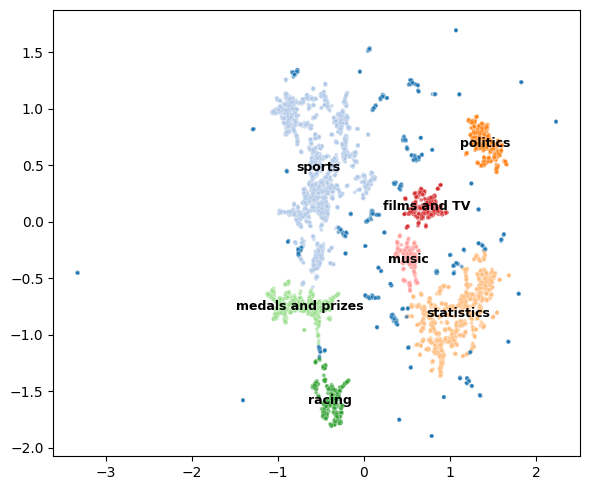

In [ ]:
cluster_names = {
	0: "sports",
	1: "politics",
	2: "racing",
 	3: "medals and prizes",
  	4: "statistics",
   	5: "films and TV",
   	7: "music",
   	-1: "noise"
   
}
plt.figure(figsize=(6, 5))
mask = labels != 6  
scatter = sns.scatterplot(x=X_reduced_n[mask, 0], y= X_reduced_n[mask, 1], hue=[cluster_names[label] for label in labels[mask]], s=nb_clusters, palette='tab20', alpha=0.6)
for cluster_id in set(labels):
	if cluster_id == -1:
		continue
	cluster_points = X_reduced_n[labels == cluster_id]
	if len(cluster_points) == 0:
		continue
	center = cluster_points.mean(axis=0)
	x_mean = cluster_points[:, 0].mean()
	y_mean = cluster_points[:, 1].mean()
 
	if cluster_id != 6:
		plt.text(x_mean, y_mean, cluster_names[cluster_id], fontsize=9, weight='bold', 
			horizontalalignment='center', verticalalignment='center')
plt.legend(loc='lower left').remove()
plt.tight_layout()
plt.savefig("clusters_scatter_train.png", dpi=300)
plt.show()


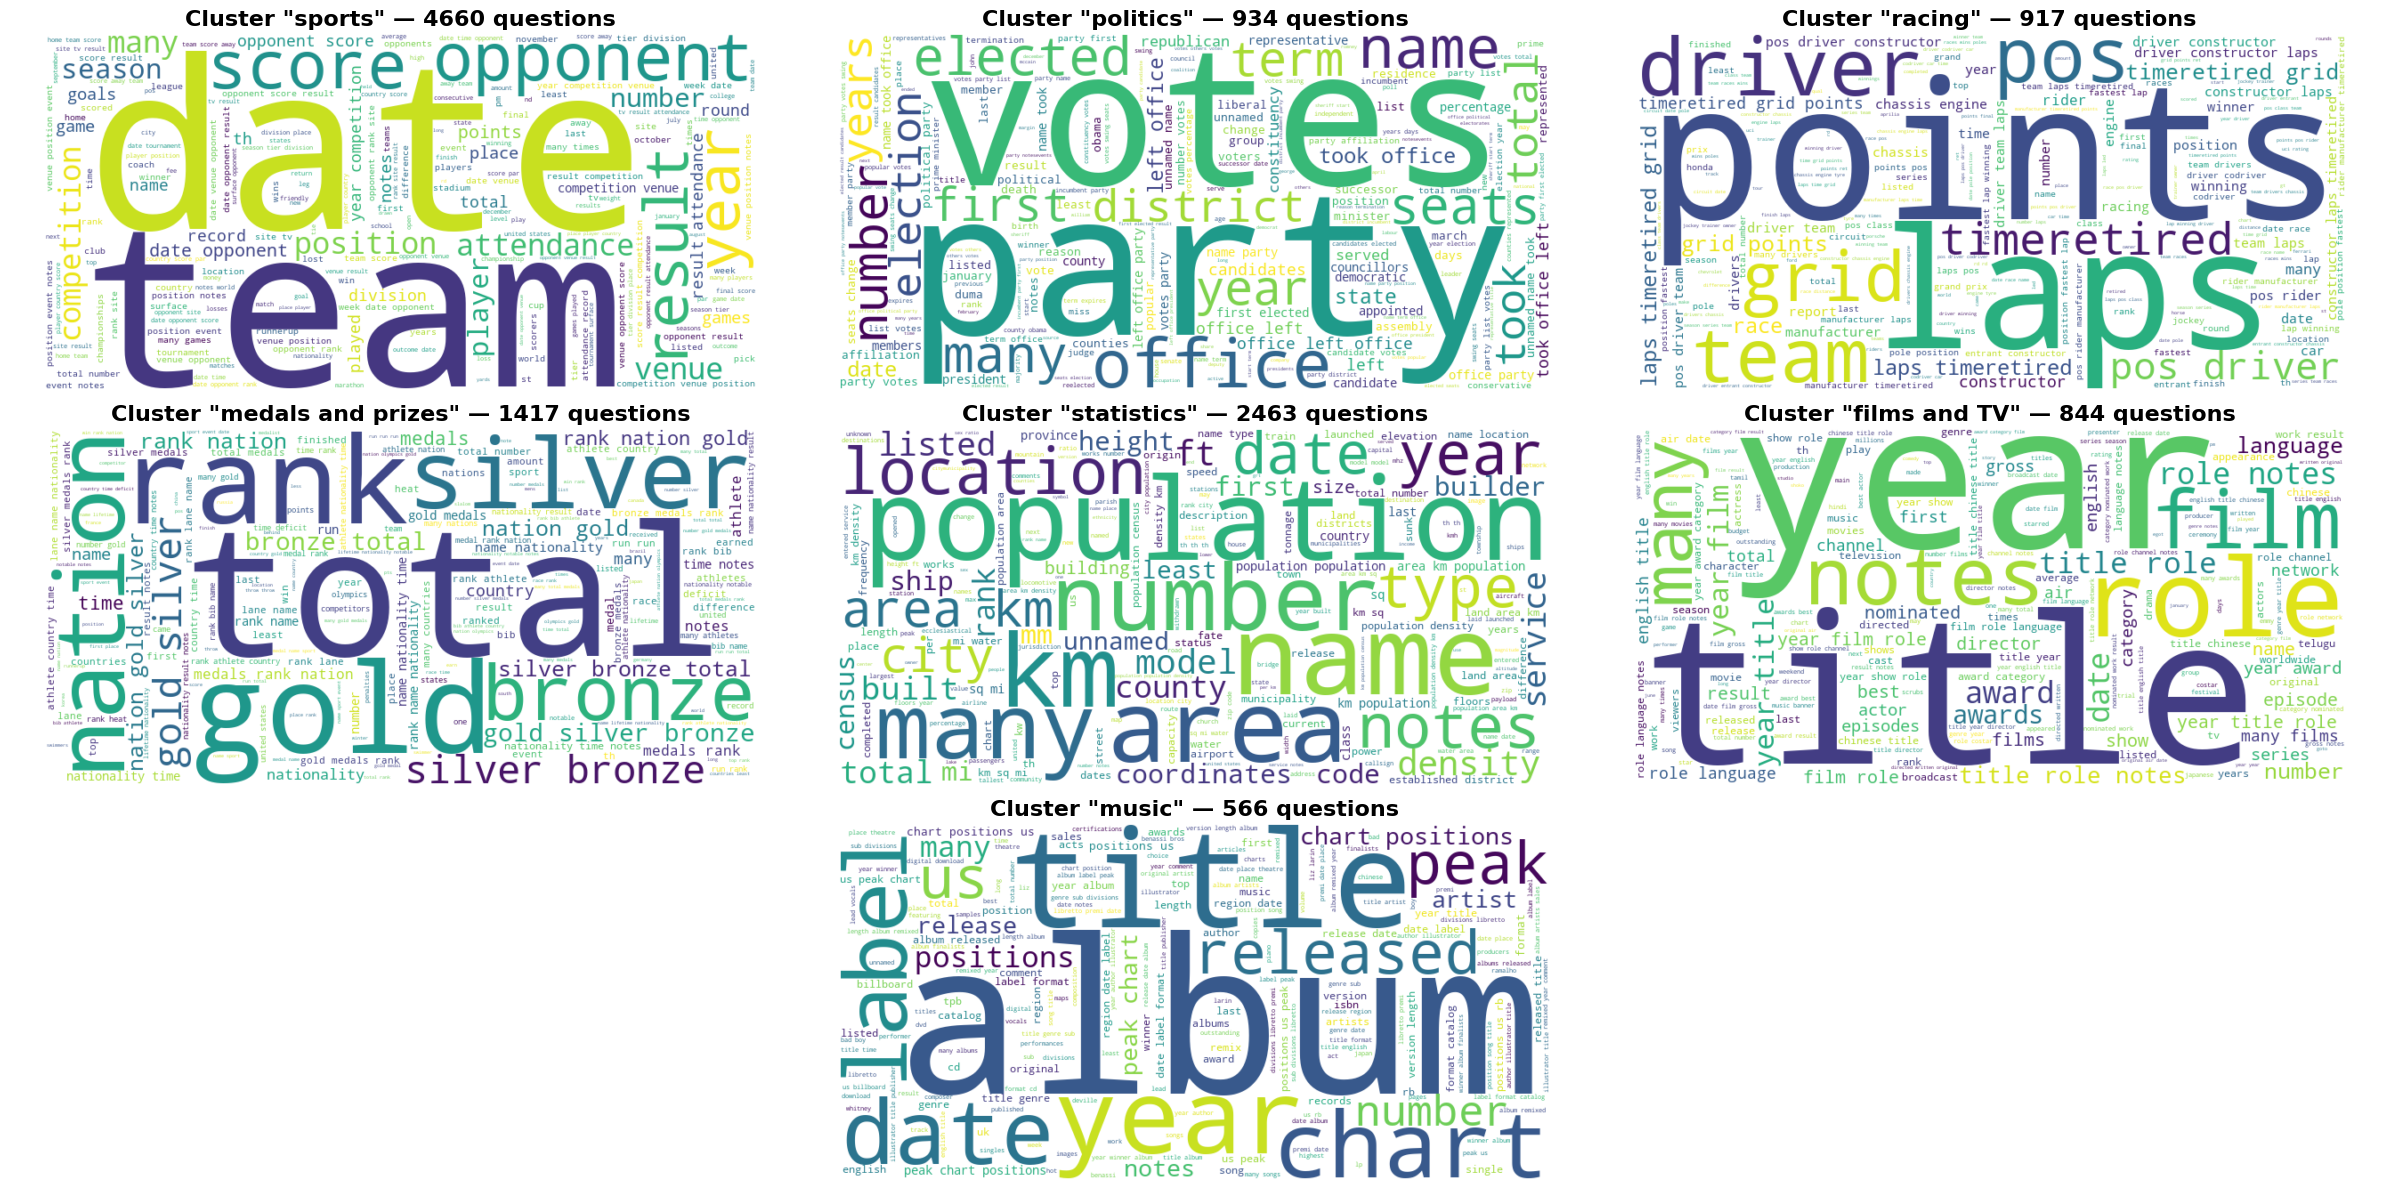

In [173]:
import math
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

cluster_ids = range(dbscan.labels_.max() + 1) # On calcule le nombre de lignes nécessaires
n_clusters = len(cluster_ids)
n_cols = 3
n_rows = math.ceil(n_clusters / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(24, 4 * n_rows))
axes = axes.flatten() # pour indexer facilement

for idx, cluster_id in enumerate(cluster_ids):
    try:
        ax = axes[idx]
        cluster_texts = [ train_texts[i] for i in range(len(train_texts)) if dbscan.labels_[i] == cluster_id ]
        if not cluster_texts:
            ax.set_title(f"Cluster {cluster_id} (vide)")
            ax.axis("off")
            continue
        # TF-IDF
        tfidf = TfidfVectorizer(ngram_range=(1, 3))
        tfidf_matrix = tfidf.fit_transform(cluster_texts)
        scores = tfidf_matrix.sum(axis=0).A1
        terms = tfidf.get_feature_names_out()
        freq_dict = dict(zip(terms, scores))
        
        # WordCloud
        wordcloud = WordCloud( width=800, height=400, background_color='white').generate_from_frequencies(freq_dict)
        ax.imshow(wordcloud, interpolation='bilinear')
        ax.axis("off")
        ax.set_title(f"Cluster \"{cluster_names[cluster_id]}\" — {len(cluster_texts)} questions", fontdict={'fontsize': 16, 'fontweight': 'bold'})
    except Exception as e:
        axes[idx].axis("off")

for j in range(idx + 1, len(axes)):
    axes[j].axis("off")
    
plt.tight_layout()
plt.savefig("wordclouds_clusters_train.png")
plt.show()

## clustering on the test data by projecting the training clusters

In [174]:
X_reduced_test = reducer.transform(test_embeddings)
X_reduced_test_n = (X_reduced_test - X_reduced_test.mean(axis=0)) / (X_reduced_test.std(axis=0)+1e-20)

c:\Users\yacin\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\sparse\_index.py:143: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [175]:
unique_clusters = [c for c in set(labels) if c != -1]
cluster_centroids = {}
for c in unique_clusters:
	pts = X_reduced_n[labels == c]
	centroid = pts.mean(axis=0)
	cluster_centroids[c] = centroid
print(f"Nombre de clusters valides (hors bruit) : {len(cluster_centroids)}")
print(cluster_centroids)


Nombre de clusters valides (hors bruit) : 8
{0: array([-0.5302912 ,  0.47660813], dtype=float32), 1: array([1.4131087 , 0.68959147], dtype=float32), 2: array([-0.3948004, -1.580623 ], dtype=float32), 3: array([-0.74323565, -0.7541747 ], dtype=float32), 4: array([ 1.0958322, -0.8139588], dtype=float32), 5: array([0.7268957 , 0.13907625], dtype=float32), 6: array([-2.890381 ,  3.1161432], dtype=float32), 7: array([ 0.5221783 , -0.33110332], dtype=float32)}


In [176]:
from scipy.spatial.distance import cdist

def assign_test_to_clusters(X_test_2d, centroids_dict, distance_threshold=None):
    cluster_ids = list(centroids_dict.keys())
    centers = np.vstack([centroids_dict[c] for c in cluster_ids])   # (K, 2)
    distances = cdist(X_test_2d, centers, metric='euclidean')       # (n_test, K)
    nearest = distances.argmin(axis=1)
    labels_pred = [cluster_ids[i] for i in nearest]

    if distance_threshold is not None:
        min_dist = distances.min(axis=1)
        labels_pred = [
            lbl if d <= distance_threshold else -1
            for lbl, d in zip(labels_pred, min_dist)
        ]
    return np.array(labels_pred)

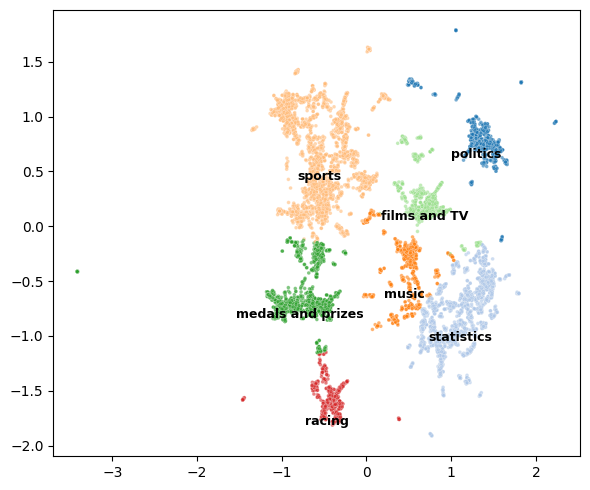

In [177]:
test_cluster_labels = assign_test_to_clusters(X_reduced_test_n, cluster_centroids)
plt.figure(figsize=(6, 5))
mask = test_cluster_labels != 6
scatter = sns.scatterplot(
    x=X_reduced_test_n[mask, 0],
    y=X_reduced_test_n[mask, 1],
    hue=[cluster_names.get(lbl, "noise") for lbl in test_cluster_labels[mask]],
    palette="tab20",
    s=7,
    alpha=0.6
)
for cluster_id in set(test_cluster_labels):
    if cluster_id in (6, -1):   # ignorer stop_words et noise
        continue
    cluster_points = X_reduced_test_n[test_cluster_labels == cluster_id]
    if len(cluster_points) == 0:
        continue
    
    x_mean = cluster_points[:, 0].mean()
    y_mean = cluster_points[:, 1].mean()

    plt.text(x_mean, y_mean - 0.2, cluster_names[cluster_id],
             fontsize=9, weight="bold",
             horizontalalignment="center",
             verticalalignment="center")

#plt.title("Attribution des points de test aux clusters (DBSCAN)")
plt.legend(loc="lower left").remove()
plt.tight_layout()
plt.savefig("clustering_test_points.png")
plt.show()


## saving the clusters

In [178]:
train_df = pd.read_csv(
    "../../WikiTableQuestions/WikiTableQuestions/data/training.tsv",
    sep="\t",
    dtype=str,
    engine="python",
    on_bad_lines="skip"
)
cluster_series = pd.Series(labels, index=train_ids)
train_df["cluster_label"] = train_df["id"].map(cluster_series)
train_df["cluster"] = train_df["cluster_label"].map(cluster_names)
train_df["cluster"] = train_df["cluster"].fillna("noise")
train_df = train_df.drop(columns=["cluster_label"])
train_df.to_csv("clustered_training.csv", sep=",", index=False)

In [179]:
test_files = [
    "random-split-1-dev.tsv",
    "random-split-2-dev.tsv",
    "random-split-3-dev.tsv",
    "random-split-4-dev.tsv",
    "random-split-5-dev.tsv"
]
base_dir = "../../WikiTableQuestions/WikiTableQuestions/data"
test_dfs = []
for file in test_files:
    df = pd.read_csv(f"{base_dir}/{file}", sep="\t", dtype=str, engine="python", on_bad_lines="skip")
    test_dfs.append(df)
test_df = pd.concat(test_dfs, ignore_index=True)
cluster_dict = dict(zip(test_ids, labels_test))
test_df["cluster_label"] = test_df["id"].map(cluster_dict)
test_df["cluster"] = test_df["cluster_label"].map(cluster_names)
test_df["cluster"] = test_df["cluster"].fillna("noise")
test_df = test_df.drop(columns=["cluster_label"])
test_df.to_csv("clustered_testing.csv", sep=",", index=False)

# cluster by answer type

In [ ]:
import pandas as pd
df = pd.read_csv("clustered_training.csv")
df["answerType"] = df["targetValue"].apply(
    lambda x: "multiple" if isinstance(x, str) and "|" in x else "singular"
)
display(df["answerType"].value_counts())
df.to_csv("clustered_training.csv", index=False)


answerType
singular    13677
multiple      434
Name: count, dtype: int64

In [4]:
import pandas as pd
df = pd.read_csv("clustered_testing.csv")
df["answerType"] = df["targetValue"].apply(
    lambda x: "multiple" if isinstance(x, str) and "|" in x else "singular"
)
display(df["answerType"].value_counts())
df.to_csv("clustered_testing.csv", index=False)


answerType
singular    13675
multiple      439
Name: count, dtype: int64